In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

#### 1] A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:
* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
     *  PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
     * GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
     * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
     * SIGNUP:  signed  up  via  the  website
     * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


#### 2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product.


Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption .


We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  --  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

In [5]:
engagement = pd.read_csv('takehome_user_engagement.csv',index_col = 0,parse_dates = True)
engagement.sort_index(inplace=True)

users = pd.read_csv("takehome_users.csv",encoding='ISO-8859-1')

In [1]:
def check(row):
   
    """"
    func to check whether a user has logged in 3 times
    in a week on three difrent days
    """
    user_id = row["object_id"]
    
    sample = engagement.loc[engagement.user_id == user_id]

    daily = pd.DataFrame(data = np.where(sample.resample("D").visited.sum() > 0,1,0),
                         index = sample.resample("D").visited.sum().index)
    
    if ((daily.resample("W").sum() > 2).sum() > 0)[0] == True:
        return "adopted_user"
    else:
        return "non_adopted_user"
    

In [6]:
users["adopted"] = users.apply(check,axis = 1)

print(users.adopted.value_counts(normalize = True))
print()
print("so only 12% user are adopted")

non_adopted_user    0.879583
adopted_user        0.120417
Name: adopted, dtype: float64

so only 12% user are adopted


In [15]:
# creating featur from account start time and last logged in time
users["account_history"] = (pd.to_datetime(users.last_session_creation_time,unit = "s") - pd.to_datetime(users.creation_time)).dt.days

In [17]:
model_data = users[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip',
                    'org_id','invited_by_user_id',"account_history",'adopted']].copy()

# encoding target variable 
model_data["adopted"] = np.where(model_data.adopted == "adopted_user",1,0)

model_data.dropna(inplace=True)

# seprating target and features 
X = model_data.drop("adopted",axis = 1)
y = model_data["adopted"]



categorical_features = ['creation_source']


X_tranformed =  pd.get_dummies(X[categorical_features]).copy()

X_numerical = X[['opted_in_to_mailing_list','enabled_for_marketing_drip',
                    'org_id','invited_by_user_id',"account_history"]]

X = pd.concat([X_numerical,X_tranformed],axis = 1)

### Training and testing Random forest classifier with default Hyperparameters

In [18]:
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_history,creation_source_GUEST_INVITE,creation_source_ORG_INVITE
0,1,0,11,10803.0,0.0,1,0
1,0,0,1,316.0,136.0,0,1
2,0,0,94,1525.0,0.0,0,1
3,0,0,1,5151.0,1.0,1,0
4,0,0,193,5240.0,5.0,1,0
...,...,...,...,...,...,...,...
11980,0,0,110,5775.0,28.0,1,0
11981,1,1,57,2527.0,0.0,0,1
11989,0,0,25,3944.0,1.0,0,1
11995,0,0,89,8263.0,0.0,0,1


In [24]:
### split the data 
np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(X,y)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3582, 7), (1194, 7), (3582,), (1194,))

In [25]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
clf.score(X_test,y_test)

0.9597989949748744

In [27]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.91      0.86      0.89       214

    accuracy                           0.96      1194
   macro avg       0.94      0.92      0.93      1194
weighted avg       0.96      0.96      0.96      1194



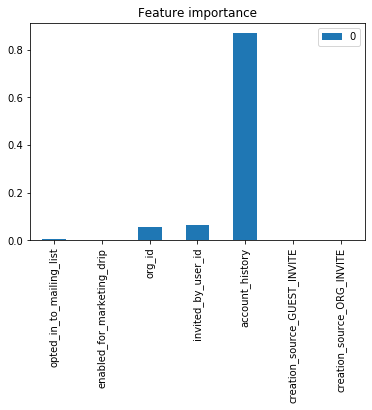

In [28]:
pd.DataFrame(clf.feature_importances_,index=list(X_train.columns)).plot(kind = "bar")
plt.title("Feature importance")
plt.show()

### Tuning Hyperparamterrs with RandomizedSearchCV

In [29]:
# setting paramater grid
grid = {'n_estimators': [i for i in range(10,200,30)],
          'max_depth': [1,2,3,4,5,6,7,8,9,10],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [i for i in range(50,300,50)],
          'min_samples_leaf': [100,200],
          "max_leaf_nodes":[4,5,6,7,8,9,10,12,13]}

grid

{'n_estimators': [10, 40, 70, 100, 130, 160, 190],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [50, 100, 150, 200, 250],
 'min_samples_leaf': [100, 200],
 'max_leaf_nodes': [4, 5, 6, 7, 8, 9, 10, 12, 13]}

In [30]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)

clf = RandomForestClassifier(n_jobs= 1)
rs_clf = RandomizedSearchCV(clf,
                            param_distributions=grid, 
                            n_iter = 250, # trying 250 random param combination from grid 
                            cv = 5, # setting Kfolds to 5 
                            verbose = 2,
                            refit=True)

rs_clf.fit(X_train,y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=190, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, ma

[CV]  n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4, total=   0.4s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=4, total=   0.4s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, ma

[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=8, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=8 
[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=8, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=8 
[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=8, total=   0.2s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=sqrt, max_depth=4 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=sqrt, max_depth=4, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=sqrt, max_

[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4 
[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4 
[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4 
[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=4, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth

[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=13, max_features=sqrt, max_depth=6, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=13, max_features=sqrt, max_depth=6 
[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=100, max_leaf_nodes=13, max_features=sqrt, max_depth=6, total=   0.3s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5, total=   0.0s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5, total=   0.0s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[

[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_de

[CV]  n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7 
[CV]  n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7 
[CV]  n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7 
[CV]  n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=190, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, m

[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=6, max_features=auto, max_depth=8, total=   0.3s
[CV] n_estimators=190, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=6, max_features=auto, max_depth=8 
[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=6, max_features=auto, max_depth=8, total=   0.4s
[CV] n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=7 
[CV]  n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=7, total=   0.1s
[CV] n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=7 
[CV]  n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=7, total=   0.1s
[CV] n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=7 
[CV]  

[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5 
[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5 
[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5 
[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=5, total=   0.1s
[CV] n_estimators=160, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[CV

[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=13, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=9, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_dept

[CV]  n_estimators=130, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=130, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=2 
[CV]  n_estimators=130, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=130, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=2 
[CV]  n_estimators=130, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=70, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=1 
[CV]  n_estimators=70, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=1, total=   0.1s
[CV] n_estimators=70, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth

[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=10, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=9, max_features=sqrt, max_depth=8 
[CV]

[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3, total=   0.3s
[CV] n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3 
[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3, total=   0.3s
[CV] n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3 
[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3, total=   0.3s
[CV] n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3 
[CV]  n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=3, total=   0.3s
[CV] n_estimators=190, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, m

[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=10, max_features=auto, max_depth=5 
[CV]  n_estimators=160, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_depth=3 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_depth=3, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_depth=3 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_depth=3, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_

[CV]  n_estimators=70, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=70, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3, total=   0.1s
[CV] n_estimators=70, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3 
[CV]  n

[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, m

[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth=8, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=7, max_features=auto, max_depth

[CV]  n_estimators=70, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=10, total=   0.1s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=auto, max_depth=5 
[C

[CV]  n_estimators=40, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=7, max_features=sqrt, max_depth=9, total=   0.1s
[CV] n_estimators=40, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=7, max_features=sqrt, max_depth=9 
[CV]  n_estimators=40, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=7, max_features=sqrt, max_depth=9, total=   0.1s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=sqrt, max_depth=2 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=sqrt, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=sqrt, max_depth=2 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=sqrt, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=sqrt, max_dep

[CV]  n_estimators=40, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=40, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=40, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=sqrt, max_depth=1 
[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=sqrt, max_depth=1, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=sqrt, max_depth=1 
[CV]  n_estimators=40, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=sqrt, max_depth=1, total=   0.1s
[CV] n_estimators=40, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=sqrt, max_depth=1 
[

[CV]  n_estimators=70, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=9, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=9, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=9, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=70, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=9, max_features=sqrt, max_depth=5 
[CV]  n_estimators=70, min_samples_split=250, min_samples_leaf=100, max_leaf_nodes=9, max_features=sqrt, max_depth=5, total=   0.1s
[CV] n_estimators=160, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=9, max_features=sqrt, max_depth=2 
[CV]  n_estimators=160, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=9, max_features=sqrt, max_depth=2, total=   0.3s
[CV] n_estimators=160, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=9, max_features=sqrt, max_depth=2 
[

[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=auto, m

[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=1, total=   0.2s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=1 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth=1, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=9, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=9, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=9, max_features=auto, max_depth=6 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=9, max_features=auto, max_depth=6, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=9, max_features=auto, max_de

[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=10, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=6, max_features=auto, max

[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3 
[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3 
[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3 
[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=9, max_features=auto, max_depth=3 
[CV]

[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=8, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=8, max_features=auto, max_depth=5 
[CV]  n_estimators=160, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=8, max_features=auto, max_depth=5, total=   0.3s
[CV] n_estimators=40, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=4 
[CV]  n_estimators=40, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=4, total=   0.1s
[CV] n_estimators=40, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=4 
[CV]  n_estimators=40, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=4, total=   0.1s
[CV] n_estimators=40, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=4 
[

[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2, total=   0.3s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2, total=   0.3s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2, total=   0.3s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=10, max_features=sqrt, max_depth=2, total=   0.3s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, ma

[CV]  n_estimators=190, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=12, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6 
[CV]  n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6, total=   0.0s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6 
[CV]  n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6, total=   0.0s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6 
[CV]  n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_depth=6, total=   0.0s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=12, max_features=auto, max_dept

[CV]  n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=1, total=   0.1s
[CV] n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=1 
[CV]  n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=1, total=   0.1s
[CV] n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=1 
[CV]  n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=4, max_features=auto, max_depth=1, total=   0.1s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=9 
[CV]  n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=9, total=   0.0s
[CV] n_estimators=10, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=9 
[CV]

[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2 
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2 
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2 
[CV]  n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=4, max_features=auto, max_depth=2, total=   0.2s
[CV] n_estimators=40, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=13, max_features=sqrt, max_depth

[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3 
[CV]  n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=3, total=   0.2s
[CV] n_estimators=130, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth

[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=auto, max_depth=4, total=   0.2s
[CV] n_estimators=130, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=auto, max_depth=4 
[CV]  n_estimators=130, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=12, max_features=auto, max_depth=4, total=   0.2s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=8 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=8, total=   0.3s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=8 
[CV]  n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=8, total=   0.3s
[CV] n_estimators=160, min_samples_split=100, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_de

[CV]  n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=8, total=   0.1s
[CV] n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=8, total=   0.1s
[CV] n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=40, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=4, max_features=sqrt, max_depth=8, total=   0.1s
[CV] n_estimators=70, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=3 
[CV]  n_estimators=70, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=3, total=   0.1s
[CV] n_estimators=70, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=8, max_features=auto, max_depth=3 
[CV]  n_e

[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.0s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.0s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.0s
[CV] n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=10, min_samples_split=250, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.0s
[CV] n_estimators=40, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=10, max_features=sqrt, max_depth=8 
[CV

[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6 
[CV]  n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6, total=   0.1s
[CV] n_estimators=70, min_samples_split=150, min_samples_leaf=200, max_leaf_nodes=6, max_features=auto, max_depth=6 
[CV]

[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=7 
[CV]  n_estimators=190, min_samples_split=200, min_samples_leaf=200, max_leaf_nodes=7, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=6 
[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=6, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=6 
[CV]  n_estimators=40, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=6, total=   0.1s
[CV] n_estimators=40, min_samples_split=100, min_samples_leaf=100, max_leaf_nodes=6, max_features=sqrt, max_depth=6 
[

[CV]  n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.3s
[CV] n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.3s
[CV] n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.3s
[CV] n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1 
[CV]  n_estimators=190, min_samples_split=50, min_samples_leaf=200, max_leaf_nodes=5, max_features=sqrt, max_depth=1, total=   0.3s
[CV] n_estimators=100, min_samples_split=200, min_samples_leaf=100, max_leaf_nodes=12, max_features=auto, max_depth=6 
[C

[CV]  n_estimators=130, min_samples_split=150, min_samples_leaf=100, max_leaf_nodes=13, max_features=sqrt, max_depth=9, total=   0.3s


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [31]:
rs_preds = rs_clf.predict(X_test)
print(classification_report(y_test,rs_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.91      0.86      0.89       214

    accuracy                           0.96      1194
   macro avg       0.94      0.92      0.93      1194
weighted avg       0.96      0.96      0.96      1194



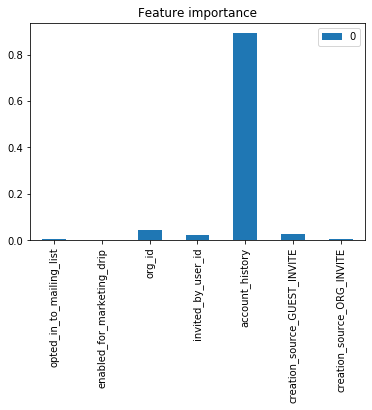

In [32]:
pd.DataFrame(rs_clf.best_estimator_.feature_importances_,index=list(X_train.columns)).plot(kind = "bar")
plt.title("Feature importance")
plt.show()

it clearly evident that the account history feature is most important feature wich the longer user stays on platform higher the chance of him bieng an adopted user so relax.inc should come up with ideas so user are tempted to log into platform reguraly.